In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '../')
import fewshot.proto.sampler
import fewshot.proto.trainer
import fewshot.data

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.transforms as transforms
from torchvision import models
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Exploring Prototypical Networks

We here check and iterate on implementation of prototypical networks. The main implementation is in `fewshot.proto` and is quite closely based on @oscarknagg's implementation [here](https://github.com/oscarknagg/few-shot/).

We're not reusing the implementation directly because I'm pretty sure there's at least one significant flaw with the implementation on that repo.



## Data Loading and Episodes

We follow the idea of putting all data in a single tensor. For an `n`-shot `k`-way episode with `q` queries, the tensor shape will be `((n+q)*k, n_channels, width, height)` - and the first dimension is split:
The first `n*k` items are the examples, and the last `q*k` examples are the queries.

We reimplemented this and added an episode viz function below:

In [3]:
train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [4]:
ds = fewshot.proto.sampler.NShotFashionDataset('../data/fashion-dataset/styles_quoted.csv',
                                               '../data/fashion-dataset/images/',
                                               classlist=None,
                                               transform=test_transform)

In [5]:
n, k, q = 2, 10, 5
sampler = fewshot.proto.sampler.NShotTaskSampler(ds, episodes_per_epoch=10, n=n, k=k, q=q)
dl = torch.utils.data.DataLoader(ds, batch_sampler=sampler, num_workers=4)

In [6]:
episode = next(iter(dl))

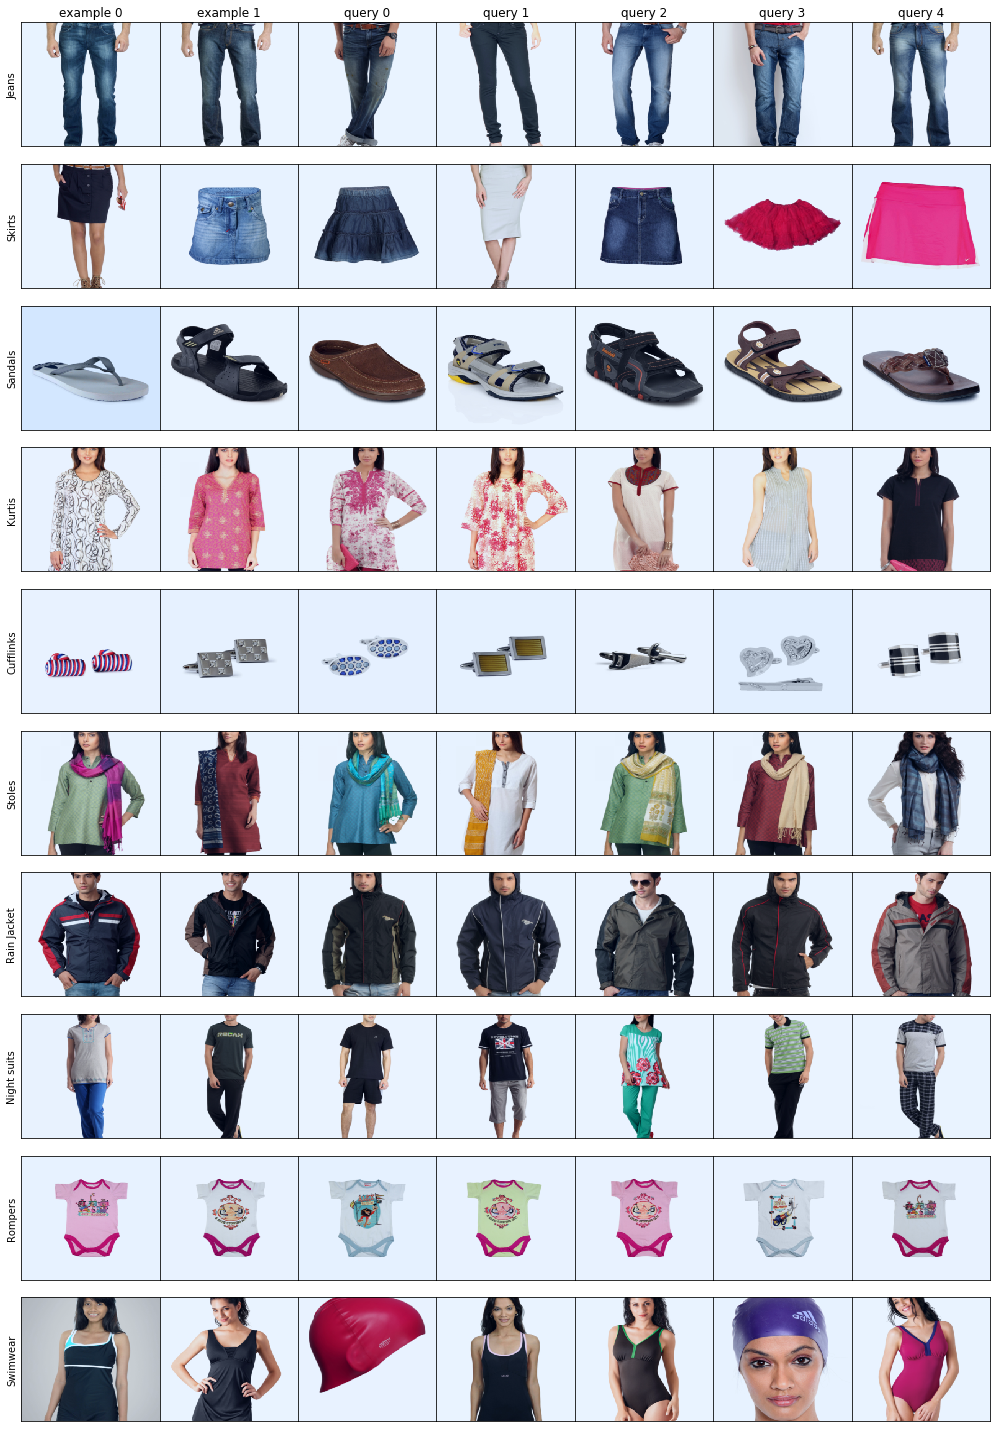

In [7]:
scale = 2
fewshot.proto.sampler.plot_nshot_episode(episode, n, k , q, scale)

## Training

Once we've set up our data appropriately, we just need to set up our training:

In [8]:
embedding_sz = 100
## smaller resnet cause overfitting. might still be way too large
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

## replacing the last layer with the dense layer we need
model.fc = nn.Linear(num_ftrs, 100)

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

Let's check that our loss goes to 0 on a single episode:

In [10]:
for _ in range(10):
    model.train()
    optimizer.zero_grad()
    X, _ = episode
    y = torch.tensor(np.broadcast_to(np.arange(10), (5, 10)).reshape((1, -1), order='F' )).squeeze()
    n_embeds = model(X[:n*k])
    q_embeds= model(X[n*k:])
    centroids = fewshot.proto.trainer.compute_centroids(n_embeds, n, k)
    distances = fewshot.proto.trainer.pairwise_distances(centroids, q_embeds, matching_fn="l2").t()
    loss = loss_func(-distances, y)
    print("loss: ", loss.item())
    loss.backward()
    optimizer.step()

loss:  1.1001026630401611
loss:  0.09554065763950348
loss:  0.01599201187491417
loss:  0.00017303467029705644
loss:  0.00018926621123682708
loss:  0.0002821731613948941
loss:  0.00044084549881517887
loss:  0.0003300094685982913
loss:  0.00015005111345089972
loss:  8.457183866994455e-05


Looks like we can safely say it works.

### Full training loop

In [11]:
train_classes = "Cufflinks, Rompers, Laptop Bag, Sports Sandals, Hair Colour, Suspenders, Trousers, Kajal and Eyeliner, Compact, Concealer, Jackets, Mufflers, Backpacks, Sandals, Shorts, Waistcoat, Watches, Pendant, Basketballs, Bath Robe, Boxers, Deodorant, Rain Jacket, Necklace and Chains, Ring, Formal Shoes, Nail Polish, Baby Dolls, Lip Liner, Bangle, Tshirts, Flats, Stockings, Skirts, Mobile Pouch, Capris, Dupatta, Lip Gloss, Patiala, Handbags, Leggings, Ties, Flip Flops, Rucksacks, Jeggings, Nightdress, Waist Pouch, Tops, Dresses, Water Bottle, Camisoles, Heels, Gloves, Duffel Bag, Swimwear, Booties, Kurtis, Belts, Accessory Gift Set, Bra".split(', ')
test_classes = "Jeans, Bracelet, Eyeshadow, Sweaters, Sarees, Earrings, Casual Shoes, Tracksuits, Clutches, Socks, Innerwear Vests, Night suits, Salwar, Stoles, Face Moisturisers, Perfume and Body Mist, Lounge Shorts, Scarves, Briefs, Jumpsuit, Wallets, Foundation and Primer, Sports Shoes, Highlighter and Blush, Sunscreen, Shoe Accessories, Track Pants, Fragrance Gift Set, Shirts, Sweatshirts, Mask and Peel, Jewellery Set, Face Wash and Cleanser, Messenger Bag, Free Gifts, Kurtas, Mascara, Lounge Pants, Caps, Lip Care, Trunk, Tunics, Kurta Sets, Sunglasses, Lipstick, Churidar, Travel Accessory".split(', ')

In [12]:
train_ds = fewshot.proto.sampler.NShotFashionDataset('../data/fashion-dataset/styles_quoted.csv',
                                               '../data/fashion-dataset/images/',
                                               classlist=train_classes,
                                               transform=test_transform)
test_ds = fewshot.proto.sampler.NShotFashionDataset('../data/fashion-dataset/styles_quoted.csv',
                                               '../data/fashion-dataset/images/',
                                               classlist=test_classes,
                                               transform=test_transform)

In [13]:
n, k, q = 2, 20, 5
train_sampler = fewshot.proto.sampler.NShotTaskSampler(train_ds, episodes_per_epoch=20, n=n, k=k, q=q)
test_sampler = fewshot.proto.sampler.NShotTaskSampler(test_ds, episodes_per_epoch=20, n=n, k=k, q=q)
train_dl = torch.utils.data.DataLoader(train_ds, batch_sampler=train_sampler, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds, batch_sampler=test_sampler, num_workers=4)

In [18]:
embedding_sz = 100
## smaller resnet cause overfitting. might still be way too large
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

## replacing the last layer with the dense layer we need
model.fc = nn.Linear(num_ftrs, embedding_sz)

In [25]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

In [20]:
fewshot.proto.trainer.run_training(model, 5, n, k, q, train_dl, test_dl, optimizer)

------------- epoch:  0
Training loss: 1.261
Validation loss: 2.180
Validation accuracy: 0.686
------------- epoch:  1
Training loss: 0.617
Validation loss: 1.622
Validation accuracy: 0.699
------------- epoch:  2
Training loss: 0.480
Validation loss: 1.563
Validation accuracy: 0.675
------------- epoch:  3
Training loss: 0.342
Validation loss: 1.298
Validation accuracy: 0.729
------------- epoch:  4
Training loss: 0.290
Validation loss: 1.313
Validation accuracy: 0.710


And for 1-shot learning:

In [26]:
n, k, q = 1, 20, 5
train_sampler = fewshot.proto.sampler.NShotTaskSampler(train_ds, episodes_per_epoch=20, n=n, k=k, q=q)
test_sampler = fewshot.proto.sampler.NShotTaskSampler(test_ds, episodes_per_epoch=20, n=n, k=k, q=q)
train_dl = torch.utils.data.DataLoader(train_ds, batch_sampler=train_sampler, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds, batch_sampler=test_sampler, num_workers=4)

In [27]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()

In [28]:
fewshot.proto.trainer.run_training(model, 5, n, k, q, train_dl, test_dl, optimizer)

------------- epoch:  0
Training loss: 3.123
Validation loss: 3.812
Validation accuracy: 0.576
------------- epoch:  1
Training loss: 1.403
Validation loss: 2.844
Validation accuracy: 0.604
------------- epoch:  2
Training loss: 0.899
Validation loss: 2.621
Validation accuracy: 0.605
------------- epoch:  3
Training loss: 0.673
Validation loss: 2.055
Validation accuracy: 0.608
------------- epoch:  4
Training loss: 0.517
Validation loss: 1.833
Validation accuracy: 0.611


In [29]:
n, k, q = 2, 5, 5
train_sampler = fewshot.proto.sampler.NShotTaskSampler(train_ds, episodes_per_epoch=20, n=n, k=k, q=q)
test_sampler = fewshot.proto.sampler.NShotTaskSampler(test_ds, episodes_per_epoch=20, n=n, k=k, q=q)
train_dl = torch.utils.data.DataLoader(train_ds, batch_sampler=train_sampler, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds, batch_sampler=test_sampler, num_workers=4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
fewshot.proto.trainer.run_training(model, 10, n, k, q, train_dl, test_dl, optimizer)

------------- epoch:  0
Training loss: 0.163
Validation loss: 0.767
Validation accuracy: 0.886
------------- epoch:  1
Training loss: 0.211
Validation loss: 1.135
Validation accuracy: 0.822
------------- epoch:  2
Training loss: 0.176
Validation loss: 0.674
Validation accuracy: 0.868
------------- epoch:  3
Training loss: 0.155
Validation loss: 0.733
Validation accuracy: 0.864
------------- epoch:  4
Training loss: 0.148
Validation loss: 0.859
Validation accuracy: 0.874
------------- epoch:  5
Training loss: 0.106
Validation loss: 1.007
Validation accuracy: 0.808
------------- epoch:  6
Training loss: 0.176
Validation loss: 0.674
Validation accuracy: 0.884
------------- epoch:  7
Training loss: 0.276
Validation loss: 0.852
Validation accuracy: 0.842
------------- epoch:  8
Training loss: 0.229
Validation loss: 0.588
Validation accuracy: 0.874
------------- epoch:  9
Training loss: 0.151
Validation loss: 0.707
Validation accuracy: 0.858


In [30]:
n, k, q = 1, 5, 5
train_sampler = fewshot.proto.sampler.NShotTaskSampler(train_ds, episodes_per_epoch=20, n=n, k=k, q=q)
test_sampler = fewshot.proto.sampler.NShotTaskSampler(test_ds, episodes_per_epoch=20, n=n, k=k, q=q)
train_dl = torch.utils.data.DataLoader(train_ds, batch_sampler=train_sampler, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_ds, batch_sampler=test_sampler, num_workers=4)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_func = nn.CrossEntropyLoss()
fewshot.proto.trainer.run_training(model, 10, n, k, q, train_dl, test_dl, optimizer)

------------- epoch:  0
Training loss: 0.604
Validation loss: 1.044
Validation accuracy: 0.838
------------- epoch:  1
Training loss: 0.306
Validation loss: 1.154
Validation accuracy: 0.804
------------- epoch:  2
Training loss: 0.316
Validation loss: 0.917
Validation accuracy: 0.844
------------- epoch:  3
Training loss: 0.272
Validation loss: 0.931
Validation accuracy: 0.792
------------- epoch:  4
Training loss: 0.223
Validation loss: 1.471
Validation accuracy: 0.746
------------- epoch:  5
Training loss: 0.297
Validation loss: 0.724
Validation accuracy: 0.810
------------- epoch:  6
Training loss: 0.227
Validation loss: 0.808
Validation accuracy: 0.784
------------- epoch:  7
Training loss: 0.270
Validation loss: 0.439
Validation accuracy: 0.844
------------- epoch:  8
Training loss: 0.162
Validation loss: 0.703
Validation accuracy: 0.818
------------- epoch:  9
Training loss: 0.207
Validation loss: 0.719
Validation accuracy: 0.844
